In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, Simulation
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

from relaxation.estimators import relaxation_finder_collision
import logging
import sys, os
from settings import DFS_PATH
from utils.utils import plot_mean_std, delete_dfs
import scipy.optimize

matplotlib.rcParams["figure.dpi"] = 150
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [2]:
def standartize(arr):
    return (arr - np.mean(arr))/np.std(arr)

In [3]:
with client.Session() as session:
    query = (session.query(Simulation.id, Simulation.particles, Simulation.group_name)
                 .where(Simulation.group_name.in_(["ER 5", "ER 6.1", "ER 6.2"] ))
                 .order_by(Simulation.start_time)).all()[:]
# query = [x[1] for x in query]
print(len(query))

5066


In [4]:
query[0]

(8400, 37, 'ER 5')

In [5]:
%%time
item = client.query_simulation(id=query[0][0], full_load=False)
item.load_history()

CPU times: user 90.7 ms, sys: 161 ms, total: 252 ms
Wall time: 2.19 s


In [6]:
item.history.keys()

dict_keys(['BInertia', 'IE', 'KE', 'L', 'LJ_force', 'OMEGA', 'PE', 'collisions', 'rs', 'time', 'vs'])

In [7]:
delete_list = []
def f(sid):
    item = client.query_simulation(id=sid, full_load=False)
    return item

In [8]:
items = [f(x) for x, n, _ in tqdm(query[:])]
print("items to delete: ",len(delete_list))

100%|██████████| 5066/5066 [01:04<00:00, 78.89it/s]

items to delete:  0


In [9]:
def smoothen(df, time_window):
    if time_window<0:
        return df
    window = len(df.loc[0:time_window])
    df_smooth = df.rolling(window, center=True).mean()
    
    if "total_L" in df and "Iz" in df and "total_KE" in df and "N" in df:
        df_smooth["omega_MLE"] = df_smooth["total_L"]/df_smooth["Iz"]
        df_smooth["beta_MLE"] = (1/3 * (2 * df["total_KE"] + 
                                        df.omega_MLE**2 * df["Iz"] 
                                        - 2 * df["total_L"] * df.omega_MLE)/df["N"] )**-1 
    return df_smooth

def concat(dfs, key=None):
    if key is None:
        df = pd.concat([df for df in dfs],axis=1)
    else:
        df = pd.concat([df[key] for df in dfs],axis=1)
    df.columns = range(len(df.columns))
    return df


In [10]:
items = [x for x in items if x is not None]
items = sorted(items, key=lambda x: x.particles)
Ns = sorted(list(set([x.particles for x in items])))
group_relaxed = ["ER 6.1", "ER 6.2"]

items_5 = [x for x in items if x.group_name not in group_relaxed]
items_6 = [x for x in items if x.group_name in group_relaxed]

items_343 = [item for item in items_6 if item.particles == 343]

shift = 200

In [11]:
items_loaded = items_343[:20]
[item.load_history() for item in tqdm(items_loaded)];

100%|██████████| 20/20 [05:04<00:00, 15.22s/it]


In [12]:
item = items_loaded[0]

In [13]:
dt = item.record_interval

In [14]:
def get_df(item):
    rs = item.history["rs"]
    vs = item.history["vs"]

    Omega = item.history["L"][:,2].sum(axis=1)/(rs[:,:2]**2).sum(axis=(1,2))

    df = pd.DataFrame({
        "i":range(len(rs)),
        "O":Omega,                    
        "L":item.history["L"][:,2].sum(axis=1),
        "I":(rs[:,:2]**2).sum(axis=(1,2))


    }, index=item.history["time"])

    O = df["O"].values[:, None]
    df["T"] = np.mean(((vs[:,0] + O*rs[:,1])**2+(vs[:,1] - O*rs[:,0])**2 + (vs[:,2])**2)/3,axis=1)
    vc = vs[:,0] + 1j * vs[:,1]
    
    return df, vc

In [15]:
dfs = [get_df(item) for item in items_loaded[:20]]
df, _ = dfs[0]

<AxesSubplot:>

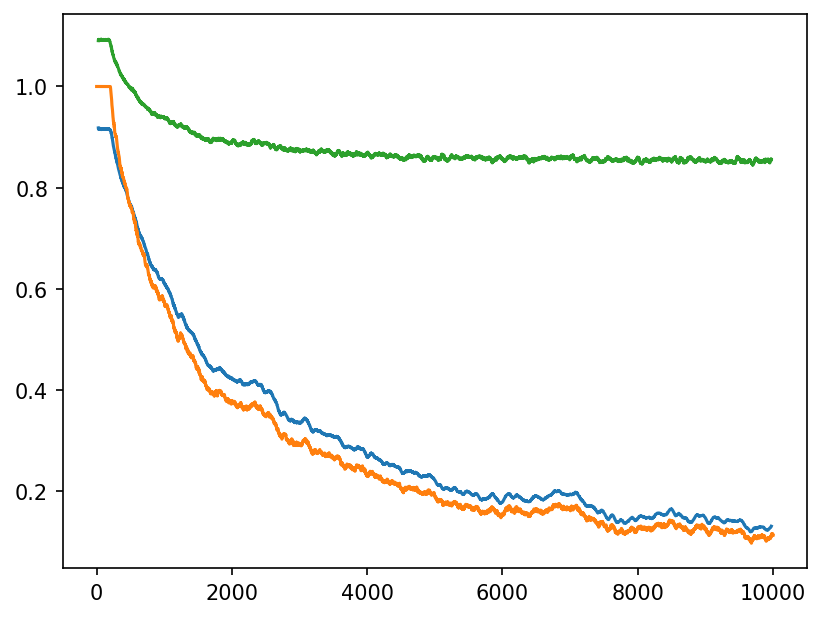

In [16]:
smoothen(df.O/df.O.loc[0], 50).plot()
smoothen(df.L/df.L.loc[0], -10).plot()
smoothen(df.I/df.I.loc[0], 50).plot()

In [17]:
def AC(x):
    n = len(x)
    ac = np.correlate(x, x, "full")
    w = np.arange(n, 0, -1)
    ac = ac[n-1:] / w
    return ac

def get_T(t, wide):
    T = []
    for df,_ in dfs:
        subdf = df.loc[t-wide/2:t+wide/2]
        T.append(subdf["T"].values)
    return np.mean(T)

def get_O(t, wide):
    O = []
    for df,_ in dfs:
        subdf = df.loc[t-wide/2:t+wide/2]
        O.append(subdf["O"].values)
    return np.mean(O)

def get_L(t, wide):
    L = []
    for df,_ in dfs:
        subdf = df.loc[t-wide/2:t+wide/2]
        L.append(subdf["L"].values)
    return np.mean(L)

In [77]:
def get_subdf(df, t, wide):
    return df.loc[t-wide/2:t+wide/2]

def get_ac(df, vc, t, wide):
    ac = []
    subdf = get_subdf(df, t, wide)
    l,r = subdf.i.iloc[[0,-1]]
    dt = df.index[1]
    
    vc_relative = vc[l:r+1,:] * np.exp(-1j*subdf.O.values.cumsum()*dt)[:,None]
    
#     ac = [AC(vc_relative[:,k]) for k in range(vc.shape[-1])]
    ac = [AC(vc[:,k]) for k in range(vc.shape[-1])]
    
    ac = np.stack(ac, axis=-1)
    return ac.mean(axis=-1)

In [78]:
from utils.ACfunctions import Cr, Cv

def get_gamma(ac, T, O, W):
    ts = np.arange(len(ac))*dt
    
    def f(gamma, W):
        if gamma < 0.0001:
            return np.inf

    #     W = 200
        c = Cv(ts[:W], gamma, T, O)
        c1 = ac[:W]
        d = c-c1
        return np.real(d.dot(d.conj())) / len(d)
    
    optres = scipy.optimize.minimize(f, 1, args=(W,))
    return {"crit": optres.fun, "gamma": optres.x[0]}

In [79]:

wide = 50.1

frames = []

for df, vc in tqdm(dfs):

    time_points = df.index.values
    time_points = time_points[(9000 > time_points) & (time_points>100)]
    time_points = time_points[::300]
#     print(len(ts))



    acs = [get_ac(df, vc, t, wide) for t in (time_points)]
    ts = np.arange(len(acs[0])) * dt
    Ts = np.array([get_subdf(df, t,wide)["T"].values.mean() for t in (time_points)])
    Os = np.array([get_subdf(df, t,wide)["O"].values.mean() for t in (time_points)])
    Ls = np.array([get_subdf(df, t,wide)["L"].values.mean() for t in (time_points)])
    
    frame = pd.DataFrame({
        "O": Os,
        "T": Ts,
        "L": Ls,
    }, index=time_points)

    frame = frame.join(pd.DataFrame([get_gamma(ac, T, O, 25) for ac, T, O in zip(acs, Ts, Os)], index=time_points))
    
    frames.append(frame)
    

100%|██████████| 20/20 [109:23:05<00:00, 19689.29s/it]  


In [80]:
print("a")

a


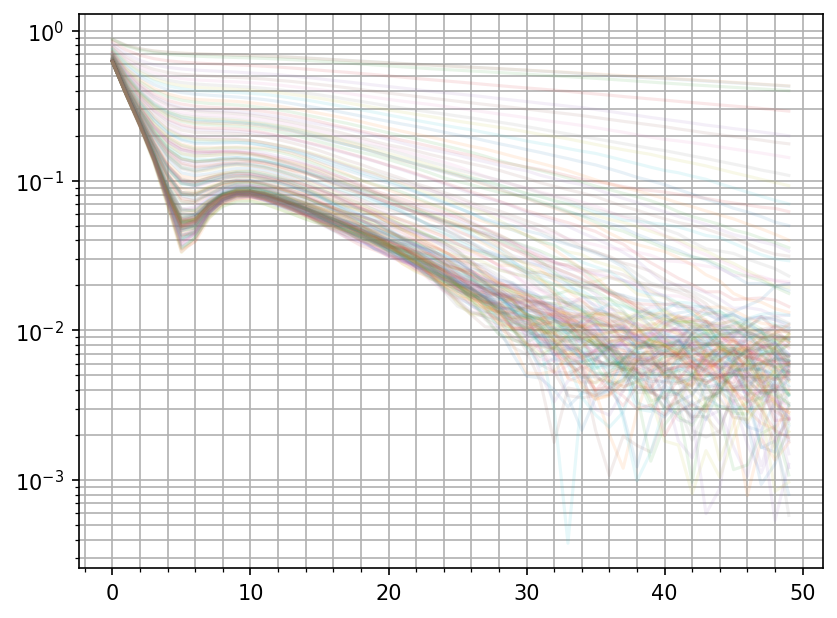

In [56]:
for ac in acs:
    plt.plot(np.abs(ac)[:50], alpha=0.1)
plt.yscale("log")
plt.minorticks_on()
plt.grid(which="both")

In [81]:
frames[-1].gamma.values[5]

4.4418887452560805

In [58]:
frames[-1].head()

,O,T,L,crit,gamma
100.199997,0.852238,0.102363,272.191620,0.016525,0.605281
160.199997,0.854480,0.102054,272.191620,0.015275,0.825685
220.199997,0.840944,0.113930,263.784424,0.010793,1.283540
280.200012,0.801360,0.135610,245.633057,0.008877,1.578008
340.200012,0.761516,0.155620,228.320099,0.007027,1.753423


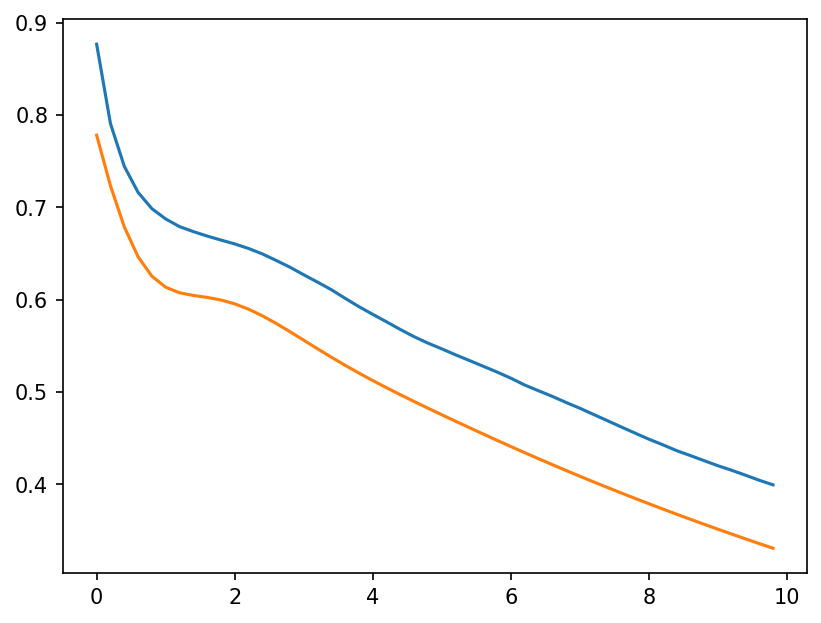

In [76]:
i = 2
plt.plot(ts[:50], np.abs(acs[i])[:50])
plt.plot(ts[:50], np.abs(Cr(ts[:50], frames[-1]["gamma"].values[i], frames[-1]["T"].values[i], frames[-1]["O"].values[i])))

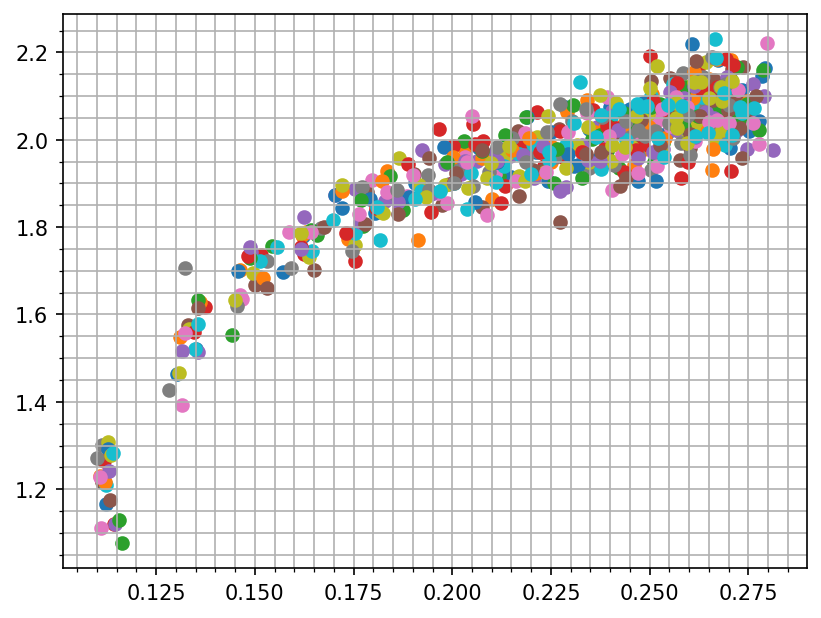

In [75]:
for frame in frames:
    
    plt.scatter(frame["T"].loc[200:2000], frame.gamma.loc[200:2000])
    
plt.minorticks_on()
plt.grid(which="both")

In [264]:
def AC(data):
    x = np.array(data) 

    # Mean
    mean = np.mean(data)

    # Variance
    var = np.var(data)

    # Normalized data
    ndata = data - mean

    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)
    return acorr

In [265]:
vc.shape

(50001, 343)

In [267]:
def get_area(ac):
    b = 2
    i = b+np.argmax(ac[b:]<0)
    return np.real(integrate.simpson(ac[:i]))

def get_area_abs(ac):
    return np.real(integrate.simpson(np.abs(ac)))
    

In [ ]:
ts = np.linspace(100,9000,100)
acs = [get_ac(t,40) for t in tqdm(ts)]
areas = np.array([get_area(ac) for ac in acs])
areas_abc = np.array([get_area_abs(ac) for ac in acs])
Ts = np.array([get_T(t,40) for t in tqdm(ts)])

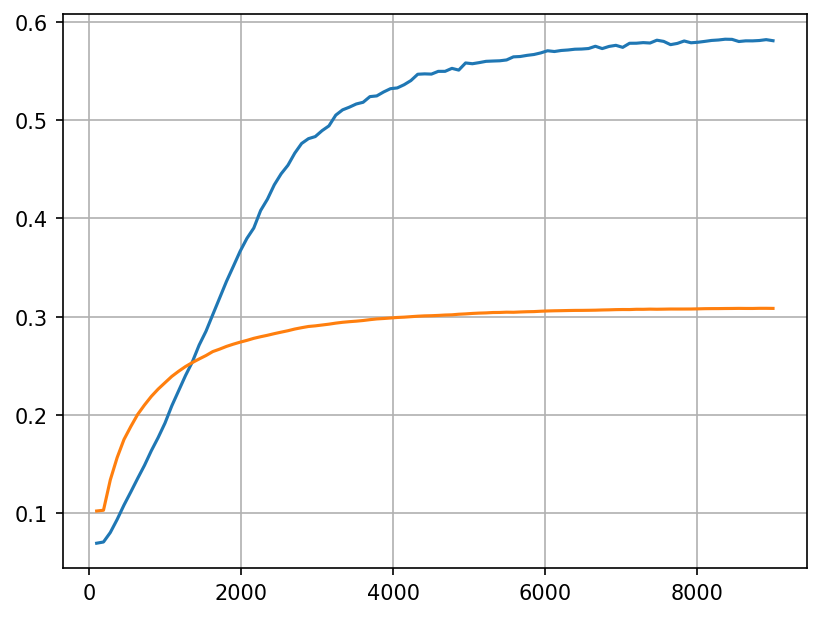

In [272]:
plt.plot(ts, 1/areas)
plt.plot(ts, Ts)
plt.grid()

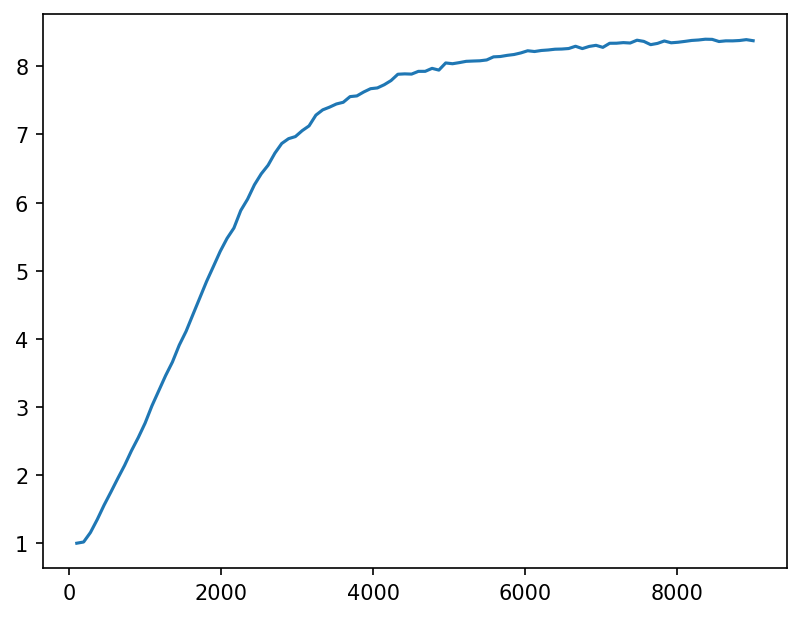

In [273]:
plt.plot(ts, 1/areas*areas[0])

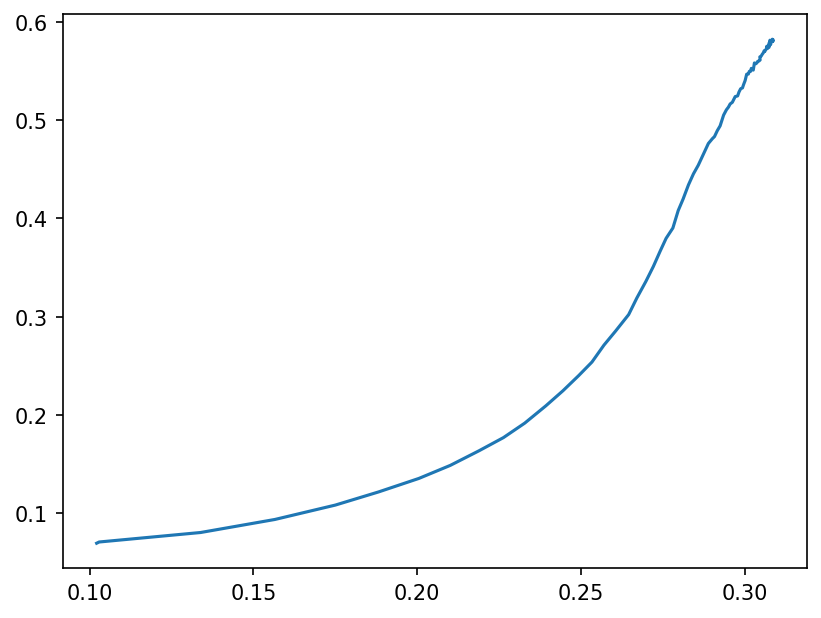

In [274]:
plt.plot(Ts, 1/areas)

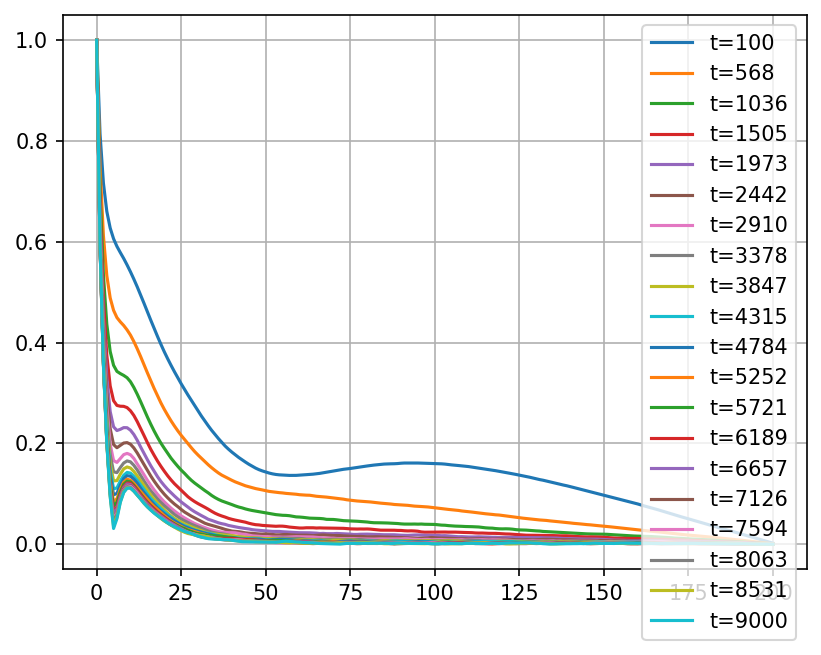

In [275]:
for t in np.linspace(100,9000,20):
    t = int(t)
    plt.plot(np.abs(get_ac(t,40)), label=f"t={t}")
    
plt.legend()
plt.grid()

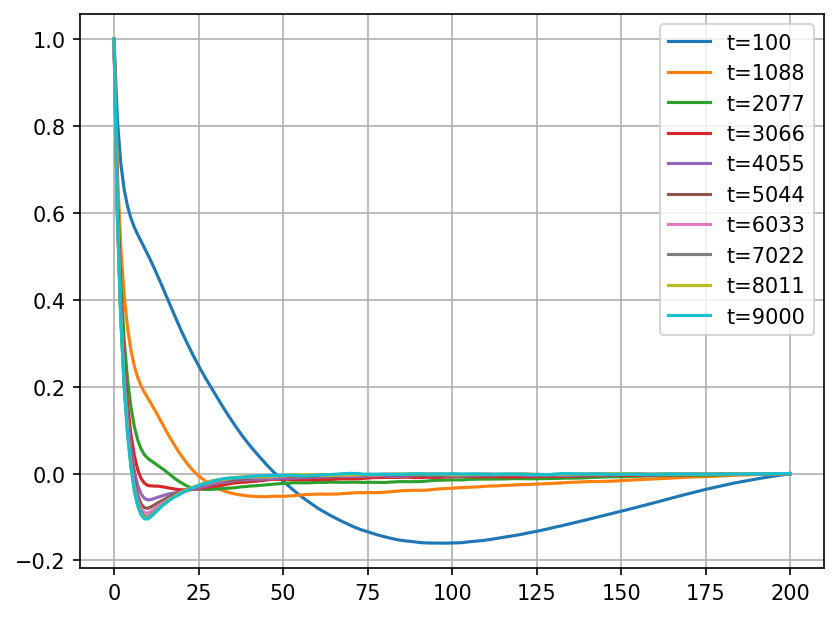

In [276]:
for t in np.linspace(100,9000,10):
    t = int(t)
    plt.plot(np.real(get_ac(t,40)), label=f"t={t}")
    
plt.legend()
plt.grid()

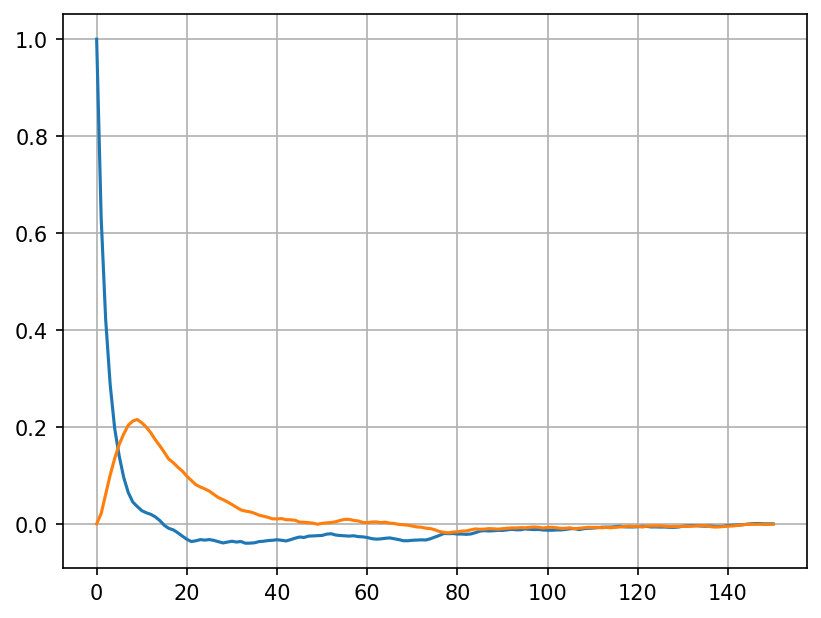

In [170]:
plt.plot(np.real(ac.mean(axis=-1)))
plt.plot(np.imag(ac.mean(axis=-1)))
# plt.plot(np.abs(ac.mean(axis=-1)))
# plt.yscale("log")
plt.grid()

In [161]:
np.correlate(vc[:,0], vc[:,0], 'full').shape

(100001,)